# Data Challenge: Smart meter is coming
by BCM Energy - Planète OUI

In [4]:
import pandas as pd
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import holidays
import math as mt

import tensorflow as tf
import keras
from keras.layers import LSTM, Dense, Flatten, Dropout, Activation, SimpleRNN
from keras.models import Sequential

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import datetime

Using TensorFlow backend.


In [5]:
X_train = pd.read_csv(
    'provided_data_and_metric/X_train_6GWGSxz.csv',
)
Y_train = pd.read_csv(
    'provided_data_and_metric/y_train_2G60rOL.csv',
)

## Data Exploration

In [6]:
X_train.head()

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,Unnamed: 9
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dealing with NaN

In [7]:
X_train.consumption[X_train.consumption.isna()]

433      NaN
613      NaN
614      NaN
615      NaN
617      NaN
          ..
405868   NaN
414108   NaN
414690   NaN
415189   NaN
417516   NaN
Name: consumption, Length: 10231, dtype: float64

DataImputer and YImputer are custom trasformers we have built to deal with NaNs.

In [8]:
class DataImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        try:
            X.drop('Unnamed: 9', axis = 1, inplace = True)
        except KeyError as e:
            pass
        X = X.interpolate(method='linear').fillna(method='bfill')
        X.time_step = pd.to_datetime(X.time_step)
        return X

In [9]:
class YImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X = X.interpolate(method='linear').fillna(method='bfill')
#         X.index = pd.to_datetime(X.index)
        return X

In [10]:
di = DataImputer()
yi = YImputer()
X_train = di.transform(X=X_train)
Y_train = yi.transform(X=Y_train)

In [11]:
X_train.head()

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2013-03-17 00:01:00,550.4000,35.0,8.9,86.0,8.9,6.0,19.0,1017.3
1,2013-03-17 00:02:00,548.6000,35.0,8.9,86.0,8.9,6.0,19.0,1017.3
2,2013-03-17 00:03:00,549.3000,35.0,8.9,86.0,8.9,6.0,19.0,1017.3
3,2013-03-17 00:04:00,549.3667,35.0,8.9,86.0,8.9,6.0,19.0,1017.3
4,2013-03-17 00:05:00,548.8909,35.0,8.9,86.0,8.9,6.0,19.0,1017.3


In [12]:
# X_train.consumption.fillna(method="ffill", inplace=True)
# X_test.consumption.fillna(method="ffill", inplace=True)
# Y_train.fillna(method="ffill", inplace=True)

In [13]:
X_train["time_step"] = pd.to_datetime(X_train["time_step"])

In [14]:
fr_holidays = holidays.France()

DO NOT DELETE THIS PLEASE OR WE DO NOT GET IS_HOLIDAYS WORKING!

In [15]:
c = 0
for i in X_train.time_step.dt.date:
    if i in fr_holidays:
        c+=1
        
print(c)

14400


Adding extra features:

Do we also want to add day of the month?

In [16]:
X_train["weekday"] = X_train.time_step.dt.dayofweek
X_train["month"] = X_train.time_step.dt.month
X_train["hour"] = X_train.time_step.dt.hour
X_train["is_weekend"] = (X_train["weekday"] > 4)*1  
X_train["is_holidays"] = (X_train.time_step.dt.date.isin(fr_holidays))*1

### Visualizing the Data

There is on average more consumption during weekends, as expected.

In [17]:
X_train[["consumption", "is_weekend"]].groupby("is_weekend").mean()

,consumption
is_weekend,
0,298.491884
1,315.715797


---

Weekday:

In [18]:
X_train[["consumption", "weekday"]].groupby("weekday").mean()

,consumption
weekday,
0,302.595452
1,314.806979
2,294.324385
3,294.144759
4,286.089830
5,315.718187
6,315.713463


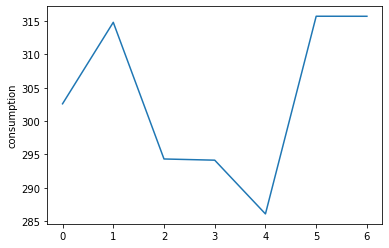

In [19]:
sns.lineplot(x=np.arange(0,7), y="consumption", data=X_train.groupby("weekday").mean())

month:

In [20]:
X_train[["consumption", "month"]].groupby("month").mean()

,consumption
month,
3,361.419421
4,296.177572
5,283.980685
6,274.367403
7,248.382001
8,223.994448
9,281.311602
10,363.227440
11,381.213867


Significant drop in consumption over the summer! We do not have data for January, February. 

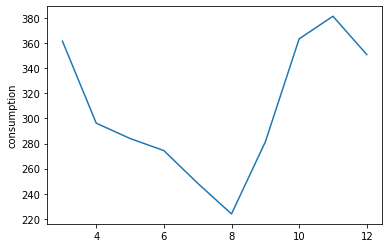

In [21]:
sns.lineplot(x=np.arange(3,13), y="consumption", data=X_train.groupby("month").mean())

In the afternoon, the most consumption.

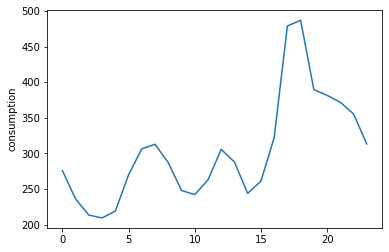

In [22]:
sns.lineplot(x=np.arange(0,24), y="consumption", data=X_train.groupby("hour").mean())

Holidays:

In [23]:
X_train.consumption.std()

341.72554808943374

In [24]:
X_train[["consumption", "is_holidays"]].groupby("is_holidays").mean()

,consumption
is_holidays,
0,304.761141
1,265.910400


Due to the big difference in consumption, it looks like the data belongs to a city in France.

In [25]:
X_train[["consumption", "is_holidays"]].groupby("is_holidays").std()

,consumption
is_holidays,
0,344.159031
1,261.896030


Plots:

In [26]:
# fig, axs = plt.subplots(2,2, figsize=(15,15))
# axs[0,0].scatter(X_train.consumption[Y_train.washing_machine > 0], Y_train.washing_machine[Y_train.washing_machine > 0], c="red")
# axs[0,0].scatter(X_train.consumption[Y_train.washing_machine == 0], Y_train.washing_machine[Y_train.washing_machine == 0], c="blue")
# axs[0,1].scatter(X_train.consumption, Y_train.fridge_freezer )
# axs[1,0].scatter(X_train.consumption, Y_train.TV )
# axs[1,1].scatter(X_train.consumption, Y_train.kettle)

### Analyzing the target

Weekday:
- People enjoy using the Washing Machine on Sunday

In [27]:
Y_train.groupby(X_train.weekday).mean()

,washing_machine,fridge_freezer,TV,kettle
weekday,,,,
0,5.389439,50.851487,15.410679,4.351712
1,6.025031,51.412186,14.709467,4.785899
2,4.811761,49.394849,14.731168,5.213072
3,3.953032,50.350004,14.123652,5.451252
4,4.589050,49.389511,13.251122,4.933465
5,6.485284,48.443971,14.418012,5.497252
6,9.116859,49.695682,14.698118,4.786513


Month:
- Significant increase in the use of the Washing Machine and the Kettle in November

In [28]:
Y_train.groupby(X_train.month).mean()

,washing_machine,fridge_freezer,TV,kettle
month,,,,
3,5.556400,42.320846,20.017219,4.385925
4,5.215361,41.389061,16.551459,3.776446
5,6.178312,45.784497,15.429027,1.304619
6,6.618310,50.552661,12.813130,3.917128
7,4.715941,57.546494,13.594985,1.895366
8,4.043138,55.848900,11.844897,1.720263
9,6.441809,49.565837,13.093514,3.608603
10,5.468136,53.266371,14.699599,8.066695
11,8.539906,52.057606,15.446995,13.152962


Weekend:

In [29]:
Y_train.groupby(X_train.is_weekend).mean()

,washing_machine,fridge_freezer,TV,kettle
is_weekend,,,,
0,4.960944,50.287842,14.451158,4.943425
1,7.816913,49.077362,14.559751,5.137604


Hour:
- Washing Machine used late evening
- TV from the evening
- Kettle in the afternoon around Tea Time

In [1]:
Y_train.groupby(X_train.hour).mean()

NameError: name 'Y_train' is not defined

Holidays:
- Who wants to do a Washing Machine while on holidays?

In [31]:
Y_train.groupby(X_train.is_holidays).mean()

,washing_machine,fridge_freezer,TV,kettle
is_holidays,,,,
0,5.875870,50.012378,14.517998,5.056063
1,3.047412,47.953892,13.480961,3.401253


### Adding extra features

By looking at the data, these features can be added:

In [32]:
X_train["is_breakfast"] = ((X_train.hour>5) & (X_train.hour<9))*1 
X_train["is_teatime"] = ((X_train.hour>16) & (X_train.hour<20))*1 
X_train["is_TVtime"] = ((X_train.hour>17) & (X_train.hour<23))*1
# X_train["is_working_hour"] = ((X_train.hour>7) & (X_train.hour<19))*1
X_train["is_night"] = ((X_train.hour>0) & (X_train.hour<7))*1

Let's put all in a transformer!

In [33]:
class DataAugmenter(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["time_step"] = pd.to_datetime(X["time_step"])
        X["weekday"] = X.time_step.dt.dayofweek
        X["month"] = X.time_step.dt.month
        X["hour"] = X.time_step.dt.hour
        X["is_weekend"] = (X["weekday"] > 4)*1  
        X["is_holidays"] = (X.time_step.dt.date.isin(fr_holidays))*1
        
        X["is_breakfast"] = ((X.hour>5) & (X.hour<9))*1 
        X["is_teatime"] = ((X.hour>16) & (X.hour<20))*1 
        X["is_TVtime"] = ((X.hour>17) & (X.hour<23))*1
        # X_train["is_working_hour"] = ((X_train.hour>7) & (X_train.hour<19))*1
        X["is_night"] = ((X.hour>0) & (X.hour<7))*1
        return X

---
---
---

## Modeling

### Regression, a baseline model

[MultiOutputRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html) consists of fitting one regressor per target. 

This is a simple strategy for extending regressors that do not natively support multi-target regression.

Test cold months only:

In [ ]:
# Y_train = Y_train.loc[(X_train.month<4) | (X_train.month>8)]
# X_train = X_train.loc[(X_train.month<4) | (X_train.month>8)]

In [61]:
regressor = MultiOutputRegressor(LinearRegression())

In [62]:
Y_train.head()

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


In [63]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X_train.drop('time_step', axis=1), Y_train.drop('time_step', axis=1), test_size=0.33, random_state=42)

In [64]:
regressor.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                     n_jobs=None)

In [65]:
regressor.score(x_train, y_train)

0.08838952117443302

In [66]:
regressor.score(x_valid, y_valid)

0.08495411337922906

Have a look at all the coefficients:

In [67]:
df = pd.DataFrame([i.coef_ for i in regressor.estimators_], columns=X_train.columns[1:], index=Y_train.columns[1:])

In [68]:
df

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,weekday,month,hour,is_weekend,is_holidays,is_breakfast,is_teatime,is_TVtime,is_night
washing_machine,0.035839,-0.078356,0.404696,-0.017835,0.030613,-0.324145,-0.239177,-0.012111,-0.098189,-0.226438,0.163038,2.626042,-0.672401,-6.599574,-13.179530,0.061215,-1.960592
fridge_freezer,0.018693,-0.003251,-0.877135,0.100308,1.609948,0.171661,0.044558,-0.003985,-0.314997,0.887057,-0.129080,-0.302640,-0.202643,0.662717,1.052255,1.043819,-2.314463
TV,0.006667,-0.013430,0.023265,0.055420,0.360021,-0.588281,-0.064199,-0.002278,-0.462785,-0.527293,0.332914,1.519438,-1.725014,-1.880395,4.526632,7.199559,2.523622
kettle,0.124247,-0.008821,-0.618851,-0.035192,0.469523,0.494373,0.041046,0.015254,0.838682,0.182093,-0.465762,-4.236884,4.011358,0.730873,-1.010641,-2.293211,-0.062465


What about predictions?

In [69]:
y_pred = regressor.predict(x_valid)

In [70]:
pred = pd.DataFrame(y_pred, columns=y_train.columns)
pred["time_step"] = X_train.time_step

In [71]:
pred.head()

,washing_machine,fridge_freezer,TV,kettle,time_step
0,5.573694,54.720526,11.780158,1.903262,2013-03-17 00:01:00
1,-2.702450,48.960925,7.248687,-9.013223,2013-03-17 00:02:00
2,2.004707,56.514845,9.145050,-10.006413,2013-03-17 00:03:00
3,-0.419321,54.629279,10.738990,-8.756599,2013-03-17 00:04:00
4,-0.213901,41.879107,12.169366,-13.415032,2013-03-17 00:05:00


Metric used on the website:

In [72]:
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true['washing_machine']
    pred = dataframe_y_pred['washing_machine']
    score += mt.sqrt(sum((pred.values - test.values)**2)/len(test))*5.55
    test = dataframe_y_true['fridge_freezer']
    pred = dataframe_y_pred['fridge_freezer']
    score += mt.sqrt(sum((pred.values - test.values)**2)/len(test))*49.79
    test = dataframe_y_true['TV']
    pred = dataframe_y_pred['TV']
    score += mt.sqrt(sum((pred.values - test.values)**2)/len(test))*14.57
    test = dataframe_y_true['kettle']
    pred = dataframe_y_pred['kettle']
    score += mt.sqrt(sum((pred.values - test.values)**2)/len(test))*4.95
    score /= 74.86
    return score

In [73]:
metric_nilm(y_valid, pred)

48.04492175166785

##### Test Submission

In [74]:
X_test = pd.read_csv(
    'provided_data_and_metric/X_test_c2uBt2s.csv', 
)
X_test.drop('Unnamed: 9', axis = 1, inplace = True)

Save time for later

In [75]:
time = X_test["time_step"]

In [76]:
X_test = di.transform(X=X_test)
ag = DataAugmenter()
X_test = ag.transform(X=X_test)

In [77]:
X_test.head()

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,weekday,month,hour,is_weekend,is_holidays,is_breakfast,is_teatime,is_TVtime,is_night
0,2014-01-01 00:00:00,312.2222,30.00,8.400000,86.000000,8.400000,5.600000,17.0,1016.600,2,1,0,0,0,0,0,0,0
1,2014-01-01 00:01:00,318.8750,29.95,8.401667,85.983333,8.401667,5.616667,16.9,1016.615,2,1,0,0,0,0,0,0,0
2,2014-01-01 00:02:00,314.3000,29.90,8.403333,85.966667,8.403333,5.633333,16.8,1016.630,2,1,0,0,0,0,0,0,0
3,2014-01-01 00:03:00,311.4444,29.85,8.405000,85.950000,8.405000,5.650000,16.7,1016.645,2,1,0,0,0,0,0,0,0
4,2014-01-01 00:04:00,310.0000,29.80,8.406667,85.933333,8.406667,5.666667,16.6,1016.660,2,1,0,0,0,0,0,0,0


In [78]:
y_pred = regressor.predict(X_test.iloc[:,1:])

In [79]:
pred = pd.DataFrame(y_pred, columns=Y_train.columns[1:])
pred= pd.concat([time, pred], axis=1)

In [80]:
pred.head()

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2014-01-01T00:00:00.0,6.670909,42.653683,12.640056,9.277171
1,2014-01-01T00:01:00.0,6.932611,42.776100,12.681377,10.108904
2,2014-01-01T00:02:00.0,6.791923,42.688638,12.647844,9.545616
3,2014-01-01T00:03:00.0,6.712856,42.633316,12.625773,9.195959
4,2014-01-01T00:04:00.0,6.684365,42.604374,12.613111,9.021639


In [ ]:
pred.to_csv("test_submission.csv", index=False)

### Preprocessing

Build a custom OneHotEncoder

In [ ]:
class MyOneHotEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.all_possible_hours = np.arange(0, 24)
        self.all_possible_weekdays = np.arange(0, 7)
        self.all_possible_months = np.arange(1, 13)
        self.ohe_hours = OneHotEncoder(drop="first")
        self.ohe_weekdays = OneHotEncoder(drop="first")
        self.ohe_months = OneHotEncoder(drop="first")
    
    def fit(self, X, y=None):
        self.ohe_hours.fit(self.all_possible_hours.reshape(-1,1))
        self.ohe_weekdays.fit(self.all_possible_weekdays.reshape(-1,1))
        self.ohe_months.fit(self.all_possible_months.reshape(-1,1))
        return self

    def transform(self, X, y=None):
        hours = pd.DataFrame(self.ohe_hours.transform(X.hour.values.reshape(-1,1)).toarray(), 
                             columns=["hour_"+str(i) for i in range(1, 24)])
        weekdays = pd.DataFrame(self.ohe_weekdays.transform(X.weekday.values.reshape(-1,1)).toarray(), 
                             columns=["weekday_"+str(i) for i in range(1, 7)])
        months = pd.DataFrame(self.ohe_months.transform(X.month.values.reshape(-1,1)).toarray(), 
                             columns=["month_"+str(i) for i in range(2, 13)])
        X = pd.concat([X, hours, weekdays, months], axis=1)
        return X

In [ ]:
oh = MyOneHotEncoder()
oh.fit(X_train)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
x_train = oh.transform(X_train)

Testing Pipeline:

In [ ]:
X_train = pd.read_csv(
    'provided_data_and_metric/X_train_6GWGSxz.csv',
)
Y_train = pd.read_csv(
    'provided_data_and_metric/y_train_2G60rOL.csv',
)

It doesn't work if I uncomment. Why?

In [ ]:
p = Pipeline([
    (
        '1',
        DataImputer()
    ),
    (
        '2',
        DataAugmenter()
    ),
    (
        '3',
        MyOneHotEncoder()
    ),
])

In [ ]:
p.fit(X_train)

In [ ]:
p.transform(X_train)

## Predicting if appliance is on or off
There is a huge difference in consumption when an appliance is on or off.

Fridge:

In [ ]:
Y_train.fridge_freezer[Y_train.fridge_freezer != 0].mean()

In [ ]:
Y_train.fridge_freezer.mean()

Kettle:

In [ ]:
Y_train.kettle[Y_train.kettle != 0].mean()

In [ ]:
Y_train.kettle.mean()

Washing Machine:

In [ ]:
Y_train.washing_machine[Y_train.washing_machine != 0].mean()

In [ ]:
Y_train.washing_machine.mean()

The TV is always on:

In [ ]:
(Y_train.TV != 0).sum() == len(Y_train)

In [ ]:
Y_train.TV.std()

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs[0,0].scatter(X_train.consumption[Y_train.washing_machine > 0], Y_train.washing_machine[Y_train.washing_machine > 0], c="red")
axs[0,0].scatter(X_train.consumption[Y_train.washing_machine == 0], Y_train.washing_machine[Y_train.washing_machine == 0], c="blue")
axs[0,1].scatter(X_train.consumption, Y_train.fridge_freezer )
axs[1,0].scatter(X_train.consumption, Y_train.TV )
axs[1,1].scatter(X_train.consumption, Y_train.kettle)

---
---
---
---
---
---
---

## RNN, testing

In [ ]:
X_train = pd.read_csv(
    'provided_data_and_metric/X_train_6GWGSxz.csv',
)
Y_train = pd.read_csv(
    'provided_data_and_metric/y_train_2G60rOL.csv',
)
X_test = pd.read_csv(
    'provided_data_and_metric/X_test_c2uBt2s.csv', 
)

In [ ]:
X_train.set_index("time_step", inplace=True)
Y_train.set_index("time_step", inplace=True)

In [ ]:
X_train = X_train.append(X_train.iloc[-1, :])
Y_train = Y_train.append(Y_train.iloc[-1, :])

In [ ]:
class DataImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        try:
            X.drop('Unnamed: 9', axis = 1, inplace = True)
        except KeyError as e:
            pass
        X = X.interpolate(method='linear').fillna(method='bfill')
        X.index = pd.to_datetime(X.index)
        return X

In [ ]:
class YImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X = X.interpolate(method='linear').fillna(method='bfill')
#         X.index = pd.to_datetime(X.index)
        return X

In [ ]:
class DataAugmenter(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X["time_step"] = pd.to_datetime(X["time_step"])
        X["weekday"] = X.time_step.dt.dayofweek
        X["month"] = X.time_step.dt.month
        X["hour"] = X.time_step.dt.hour
        X["is_weekend"] = (X["weekday"] > 4)*1  
        X["is_holidays"] = (X.time_step.dt.date.isin(fr_holidays))*1
        
        X["is_breakfast"] = ((X.hour>5) & (X.hour<9))*1 
        X["is_teatime"] = ((X.hour>16) & (X.hour<20))*1 
        X["is_TVtime"] = ((X.hour>17) & (X.hour<23))*1
        # X_train["is_working_hour"] = ((X_train.hour>7) & (X_train.hour<19))*1
        X["is_night"] = ((X.hour>0) & (X.hour<7))*1
        return X

In [ ]:
class RNNDataFormatter(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X.set_index("time_step", inplace=True)
        X = X.append(X.iloc[-1, :])
        nb_col = X.shape[1]
        return X.values.reshape((int(X_rnn.shape[0]/60), 60, nb_col))

In [ ]:
p1 = Pipeline([
    (
        '1',
        DataImputer()
    ),
    (
        '2',
        DataAugmenter()
    ),
    (
        '3',
        RNNDataFormatter()
    )
])

In [ ]:
p2 = Pipeline([
    (
        '1',
        YImputer()
    ),
    (
        '2',
        RNNDataFormatter()
    )
])

In [ ]:
X = p1.transform(X_train)

In [ ]:
Y = p2.transform(Y_train)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
x_train, y_train = X[:6000, :], Y[:6000, :, :]
x_valid, y_valid = X[6000:, :], Y[6000:, :, :]

### Baseline Model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 14]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(4, return_sequences=True)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_valid, y_valid))

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
#     plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
model.predict(x_valid).shape

### Improvements

**TO-DO** (before running code below):
- Add ColumnTransformer, to avoid scaling categorical features.
- Add DataAugmenter in the pipeline
- Check if RNNDataFormatter still works

**Issue**: The RNN returns output from sigmoid, hence between (-1, 1).

**Idea**: Normalization

Modify RNNDataFormatter to make it work with np.arrays:

In [ ]:
class RNNDataFormatter(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.X = None
    
    def fit(self, X, y=None):
        return X
    
    def transform(self, X, y=None):
        X.set_index("time_step", inplace=True)
        X = X.append(X.iloc[-1, :])
        nb_col = X.shape[1]
        X = X.reshape((int(X.shape[0]/60), 60, nb_col))
        return X

Fit StandardScaler before, gives error in Pipeline

In [ ]:
scaler_x = StandardScaler()
scaler_x.fit(X_train)

In [ ]:
scaler_y = StandardScaler()
scaler_y.fit(Y_train)

In [ ]:
p1 = Pipeline([
        (
        '1',
        DataImputer()
    ),
    (
        '2',
        scaler_x
    ),
    (
        '3',
        RNNDataFormatter()
    )
])

In [ ]:
p2 = Pipeline([
    (
        '1',
        YImputer()
    ),
    (
        '2',
        scaler_y
    ),
    (
        '3',
        RNNDataFormatter()
    )
])

In [ ]:
x_scaled = p1.transform(X_train)
y_scaled = p2.transform(Y_train)

In [ ]:
print(f"x_scaled shape is {x_scaled.shape}")
print(f"y_scaled shape is {y_scaled.shape}")

In [ ]:
x_train, y_train = x_scaled[:6000, :], y_scaled[:6000, :, :]
x_valid, y_valid = x_scaled[6000:, :], y_scaled[6000:, :, :]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 8]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(4, return_sequences=True)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))

In [ ]:
y_pred = model.predict(x_train)

In [ ]:
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 4)) #shape is now (360000, 4)

In [ ]:
mean_squared_error(y_trans.iloc[:360000, :], y_pred)

In [ ]:
y_trans.head()

In [ ]:
y_pred[:5, :]